<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-nnqf.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-nnqf.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-deepar.ipynb&fileName=gefcom14-s-nnqf"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Download data

In [1]:
!echo "Downloading GEFCom14-S..."
!rm -R data > /dev/null
!wget -O gefcom14.zip https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip?dl=0
!unzip gefcom14 > /dev/null
!rm gefcom14.zip > /dev/null
!unzip GEFCom2014\ Data/GEFCom2014-S_V2.zip > /dev/null
!rm -R GEFCom2014\ Data > /dev/null
!mv Solar data > /dev/null
!echo "------------------------------"
!echo "Downloaded GEFCom14-S in data/"

--2021-05-15 15:22:11--  https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.18, 2620:100:6032:18::a27d:5212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/pqenrr2mcvl0hk9/GEFCom2014.zip [following]
--2021-05-15 15:22:11--  https://www.dropbox.com/s/raw/pqenrr2mcvl0hk9/GEFCom2014.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8d34bd0a06c681f7111afb9018.dl.dropboxusercontent.com/cd/0/inline/BOgtW7HXWaEUlcNTpAFeiW3U-5UX4bz6gno99t2ztu-jjxOmhUhzjf2KaO646BDG0QvStS-_C8LySV6bT4HnKuM4268oGRimT0JJ3PPjUFbMIRc3IOI83ld9-GvNeCBQooZhjIw8-rcGhx8pmaIjrnLU/file# [following]
--2021-05-15 15:22:12--  https://uc8d34bd0a06c681f7111afb9018.dl.dropboxusercontent.com/cd/0/inline/BOgtW7HXWaEUlcNTpAFeiW3U-5UX4bz6gno99t2ztu-jjxOmhUhzjf2KaO646BDG0QvStS-_C8Ly

# Select Task

In [2]:
task = 14

# Prepare data

In [3]:
import numpy as np
import pandas as pd

# only use surface solar radiation (169), surface thermal radiation (175) and top net solar radiation (178)
predictors = pd.read_csv(f'data/Task {task}/predictors{task}.csv', parse_dates=['TIMESTAMP'])\
    [['ZONEID', 'TIMESTAMP', 'VAR169', 'VAR175', 'VAR178']].set_index('TIMESTAMP')
train = pd.read_csv(f'data/Task {task + 1}/train{task + 1}.csv', parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')
benchmark = pd.read_csv(f"data/Task {task}/benchmark{'0' + str(task) if task < 10 else task}.csv",
                        parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')

solar_plants = [train[train['ZONEID'] == i][['POWER']].rename({'POWER': f'ZONEID {i}'}, axis='columns')
                for i in [1,2,3]]
train_data = pd.concat(solar_plants, axis=1)

predictors_categories = [predictors[predictors['ZONEID'] == i][['VAR169', 'VAR175', 'VAR178']]
                             .rename({'VAR169': f'SURFACE SOLAR RADIATION {i}',
                                      'VAR175': f'SURFACE THERMAL RADIATION {i}',
                                      'VAR178': f'TOP NET SOLAR RADIATION {i}'}, axis='columns')
                         for i in [1,2,3]]
predictor_data = pd.concat(predictors_categories, axis=1)

In [4]:
gefcom14_metadata = {
    'num_series': 3,
    'num_steps': len(predictor_data),
    'prediction_length': len(benchmark) // 3,
    'start': predictor_data.index[0]
}

In [5]:
for i in range(1, 4):
    predictor_data[f'SURFACE SOLAR RADIATION {i}'] /= predictor_data[f'SURFACE SOLAR RADIATION {i}'].max()
    predictor_data[f'SURFACE THERMAL RADIATION {i}'] /= predictor_data[f'SURFACE THERMAL RADIATION {i}'].max()
    predictor_data[f'TOP NET SOLAR RADIATION {i}'] /= predictor_data[f'TOP NET SOLAR RADIATION {i}'].max()

In [6]:
predictor_zones = []
train_data_zones = []

for zoneid in range(1, 4):
    predictor = predictor_data[[f'SURFACE SOLAR RADIATION {zoneid}', f'SURFACE THERMAL RADIATION {zoneid}', f'TOP NET SOLAR RADIATION {zoneid}']]
    predictor_zones.append(predictor)
    train_data_zone = train_data[[f'ZONEID {zoneid}']]
    train_data_zones.append(train_data_zone)

In [7]:
x_input_zones = []
y_output_zones = []

for predictor, train_data in zip(predictor_zones, train_data_zones):
    x_input_df = predictor[:-gefcom14_metadata['prediction_length']]
    x_input = np.array(x_input_df)
    x_input_zones.append(x_input)
    y_output = np.array(train_data[:-gefcom14_metadata['prediction_length']])
    y_output_zones.append(y_output)

# NNQF

In [8]:
import numpy as np
from sklearn.neighbors import NearestNeighbors as nn_fun

def nnqf_filter(x_input, 
                y_output, 
                num_neighbors = 10, 
                q_quantile = 0.5, 
                var_weighting = True, 
                minkowski_dist = 2):
    """
    Parameters
    ----------
    x_input : numpy array ;
    Input matrix of dimension (N,S), with N representing the number of
    samples and S the number of features

    y_output : numpy array ;
    Output vector of dimension (N,)

    num_neighbors : int, default = 10 ;
    Number of nearest neighbors that the filter is going to search for     

    q_quantile : float, default = 0.5 ;
    Must be a value between 0 and 1. 
    Probability of the quantile that is going to be calculated from the 
    nearest neighbors output values      

    var_weighting : bool, default = True ;
    Value defining if the columns of the input matrix are going to be multiplied 
    by the inverse of their variance

    minkowski_dist : int, default = 2 ;
    Parameter used to define the type of minkoswki distance used to calculate 
    the nearest neighbors

    Returns
    -------
    yq_output : numpy array ;
    New output vector containing the quantiles of the output values of the
    input's nearest neighbors

    """
    # --
    # Each column of the input matrix is multiplied by the inverse of its variance, 
    # in order to avoid a feature with a huge scale to overpower the others at the 
    # moment of calculating the distances

    if var_weighting:
        var_weights = np.var(x_input, axis=0)
        x_input = var_weights ** (-1) * x_input    

    # --
    # We calculate the nearest neighbor of each feature vector within the input matrix
    # and obtain their corresponding indices
    # The distance used is the minkowski distance with p = minkowski_dist

    x_neighbors = nn_fun(n_neighbors=num_neighbors, algorithm='auto', p=minkowski_dist).fit(x_input)
    dist, indx = x_neighbors.kneighbors(x_input)


    # --
    # We create a matrix containing the output values of nearest neighbors of
    # each input vector

    y_neighbors = y_output[indx[0,:]].T
    for i in range(1, np.size(x_input, 0)):
        values_to_add = y_output[indx[i,:]].T
        y_neighbors = np.vstack([y_neighbors, values_to_add])

    # --
    # We calculate the q_quantile of the nearest neighbors output values
    # and create with them a new output vector yq_output

    yq_output = np.quantile(y_neighbors, q=q_quantile, axis=1)
        
    return yq_output

In [9]:
yq_output_zones = []

for x_input, y_output in zip(x_input_zones, y_output_zones):
    yq_output = nnqf_filter(x_input=x_input, y_output=y_output,
                            q_quantile=[p / 100 for p in range(1, 100)],
                            num_neighbors=100).T
    yq_output_df = pd.DataFrame(yq_output, index=x_input_df.index)\
        .rename(columns={p: str((p+1)/100) for p in range(99)})
    yq_output_zones.append(yq_output_df)

# Train the linear regression model (ANN6)

In [10]:
for zoneid in range(1, 4):
    # remove timecode
    predictor = predictor_zones[zoneid-1].reset_index().drop('TIMESTAMP', axis=1).rename(columns={
        f'SURFACE SOLAR RADIATION {zoneid}': 0,
        f'SURFACE THERMAL RADIATION {zoneid}': 1,
        f'TOP NET SOLAR RADIATION {zoneid}': 2})
    predictor_zones[zoneid-1] = predictor

predictor_zones[0]

,0,1,2
0,0.075036,0.034681,0.076927
1,0.155907,0.070565,0.159924
2,0.230590,0.106171,0.240292
3,0.287023,0.141938,0.304604
4,0.324356,0.180378,0.352287
...,...,...,...
18979,0.177391,0.702846,0.220841
18980,0.177391,0.738251,0.220841
18981,0.178456,0.774921,0.223835
18982,0.181670,0.811403,0.233568


## Prepare data for regression model

In [11]:
h = 24
h1 = 24

x_zones = []

for predictor in predictor_zones:
    x_pieces = []
    for i in range(h1):
        piece = predictor.drop(range(i)).reset_index().drop('index', axis=1)
        x_pieces.insert(0, piece)

    x = pd.concat(x_pieces, axis=1)
    x.index = x.index.map(lambda x: x + h1 - 1)
    x = x[:-h+1]
    x.columns = range(24 * 3)
    x_zones.append(x)

x_zones[0]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
23,0.450155,0.829704,0.516008,0.406513,0.790186,0.465510,0.376880,0.753688,0.429557,0.361453,0.718264,0.409672,0.359525,0.686121,0.406237,0.359525,0.652336,0.406237,0.359525,0.617766,0.406237,0.359525,0.583370,0.406237,0.359525,0.550289,0.406237,0.359525,0.518818,0.406237,0.359525,0.487744,0.406237,0.359525,0.456258,0.406237,0.359525,0.424661,0.406237,0.359525,0.392225,0.406237,0.359525,0.359354,0.406247,0.359525,0.324665,0.406247,0.359525,0.289591,0.406247,0.357292,0.253755,0.401204,0.343937,0.217987,0.381666,0.324356,0.180378,0.352287,0.287023,0.141938,0.304604,0.230590,0.106171,0.240292,0.155907,0.070565,0.159924,0.075036,0.034681,0.076927
24,0.050003,0.037880,0.058629,0.450155,0.829704,0.516008,0.406513,0.790186,0.465510,0.376880,0.753688,0.429557,0.361453,0.718264,0.409672,0.359525,0.686121,0.406237,0.359525,0.652336,0.406237,0.359525,0.617766,0.406237,0.359525,0.583370,0.406237,0.359525,0.550289,0.406237,0.359525,0.518818,0.406237,0.359525,0.487744,0.406237,0.359525,0.456258,0.406237,0.359525,0.424661,0.406237,0.359525,0.392225,0.406237,0.359525,0.359354,0.406247,0.359525,0.324665,0.406247,0.359525,0.289591,0.406247,0.357292,0.253755,0.401204,0.343937,0.217987,0.381666,0.324356,0.180378,0.352287,0.287023,0.141938,0.304604,0.230590,0.106171,0.240292,0.155907,0.070565,0.159924
25,0.096816,0.076731,0.116198,0.050003,0.037880,0.058629,0.450155,0.829704,0.516008,0.406513,0.790186,0.465510,0.376880,0.753688,0.429557,0.361453,0.718264,0.409672,0.359525,0.686121,0.406237,0.359525,0.652336,0.406237,0.359525,0.617766,0.406237,0.359525,0.583370,0.406237,0.359525,0.550289,0.406237,0.359525,0.518818,0.406237,0.359525,0.487744,0.406237,0.359525,0.456258,0.406237,0.359525,0.424661,0.406237,0.359525,0.392225,0.406237,0.359525,0.359354,0.406247,0.359525,0.324665,0.406247,0.359525,0.289591,0.406247,0.357292,0.253755,0.401204,0.343937,0.217987,0.381666,0.324356,0.180378,0.352287,0.287023,0.141938,0.304604,0.230590,0.106171,0.240292
26,0.149261,0.116550,0.177444,0.096816,0.076731,0.116198,0.050003,0.037880,0.058629,0.450155,0.829704,0.516008,0.406513,0.790186,0.465510,0.376880,0.753688,0.429557,0.361453,0.718264,0.409672,0.359525,0.686121,0.406237,0.359525,0.652336,0.406237,0.359525,0.617766,0.406237,0.359525,0.583370,0.406237,0.359525,0.550289,0.406237,0.359525,0.518818,0.406237,0.359525,0.487744,0.406237,0.359525,0.456258,0.406237,0.359525,0.424661,0.406237,0.359525,0.392225,0.406237,0.359525,0.359354,0.406247,0.359525,0.324665,0.406247,0.359525,0.289591,0.406247,0.357292,0.253755,0.401204,0.343937,0.217987,0.381666,0.324356,0.180378,0.352287,0.287023,0.141938,0.304604
27,0.201841,0.155451,0.237863,0.149261,0.116550,0.177444,0.096816,0.076731,0.116198,0.050003,0.037880,0.058629,0.450155,0.829704,0.516008,0.406513,0.790186,0.465510,0.376880,0.753688,0.429557,0.361453,0.718264,0.409672,0.359525,0.686121,0.406237,0.359525,0.652336,0.406237,0.359525,0.617766,0.406237,0.359525,0.583370,0.406237,0.359525,0.550289,0.406237,0.359525,0.518818,0.406237,0.359525,0.487744,0.406237,0.359525,0.456258,0.406237,0.359525,0.424661,0.406237,0.359525,0.392225,0.406237,0.359525,0.359354,0.406247,0.359525,0.324665,0.406247,0.359525,0.289591,0.406247,0.357292,0.253755,0.401204,0.343937,0.217987,0.381666,0.324356,0.180378,0.352287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18979,0.177391,0.702846,0.220841,0.177391,0.670499,0.220841,0.177391,0.635450,0.220841,0.177391,0.600692,0.220841,0.177391,0.565149,0.220841,0.177391,0.529934,0.220841,0.177391,0.493703,0.220841,0.177391,0.456309,0.220841,0.177391,0.418492,0.2208

## Feature selection

In [12]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

x_new_zones = []

for x, yq_output_df in zip(x_zones, yq_output_zones):
    x_select = x[:-gefcom14_metadata['prediction_length'] + 23]
    y_select = yq_output_df[str(0.5)]

    print(x_select.shape)
    print(y_select.shape)

    support = SelectKBest(f_regression, k=30).fit(x_select, y_select).get_support(indices=True)
    print(support)

    x_new = x.loc[:, support]
    x_new_zones.append(x_new)

(18240, 72)
(18240,)
[ 7 10 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 49 52 55
 58 61 64 67 70 71]
(18240, 72)
(18240,)
[ 1 10 13 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 36 39 52
 55 58 61 64 67 70]
(18240, 72)
(18240,)
[ 7 10 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 32 33 49 52
 55 58 61 64 67 70]


In [13]:
# x_normalized = (x_new - x_new.mean()) / x_new.std()
# x_normalized

# Training

In [14]:
from sklearn.neural_network import MLPRegressor
from tqdm import tqdm

ensemble_size = 10

predictions_zones = []

for x_new, yq_output_df in zip(x_new_zones, yq_output_zones):
    predictions = [pd.DataFrame() for _ in range(ensemble_size)]

    for p in tqdm(range(1, 100)):
        for prediction in predictions:
            y = yq_output_df.reset_index().drop('TIMESTAMP', axis=1).drop(range(h1-1))[str(p/100)]
            model = MLPRegressor(hidden_layer_sizes=(6,))

            trained = model.fit(x_new[:-gefcom14_metadata['prediction_length']], y)
            prediction.insert(p-1, str(p/100), trained.predict(x_new[-gefcom14_metadata['prediction_length']:]))
    predictions_zones.append(predictions)

100%|██████████| 99/99 [14:11<00:00,  8.61s/it]


In [15]:
predictions_zones[0][0]

,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.4,...,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.7,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.8,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
0,0.122130,0.122267,0.130665,0.179905,0.177199,0.194649,0.193712,0.240513,0.234942,0.244899,0.244624,0.322742,0.296795,0.278675,0.295633,0.252260,0.311360,0.298847,0.368998,0.282777,0.365633,0.318709,0.391588,0.356521,0.326832,0.340550,0.362157,0.334750,0.455643,0.357587,0.374506,0.394627,0.367712,0.524918,0.378694,0.506910,0.555977,0.393957,0.398509,0.377117,...,0.488889,0.588586,0.503806,0.514444,0.636092,0.497333,0.515342,0.541835,0.685484,0.517040,0.499460,0.556617,0.533419,0.544526,0.526807,0.562829,0.594204,0.601339,0.608173,0.580555,0.672629,0.610227,0.624774,0.640201,0.609875,0.665219,0.685909,0.660732,0.648013,0.614831,0.719426,0.685812,0.666615,0.746259,0.734625,0.663833,0.804588,0.765472,0.794042,0.772782
1,0.122311,0.133996,0.139330,0.179900,0.171301,0.208693,0.220457,0.249609,0.358415,0.259449,0.241806,0.432706,0.397769,0.280163,0.289978,0.293767,0.386555,0.275991,0.440270,0.288003,0.419780,0.316241,0.582355,0.345054,0.369624,0.330552,0.362494,0.328158,0.480848,0.384005,0.380614,0.486347,0.366490,0.512351,0.380796,0.559625,0.525598,0.381099,0.411738,0.376773,...,0.492544,0.585889,0.511558,0.541148,0.638061,0.509030,0.523501,0.544551,0.680388,0.501725,0.519304,0.560438,0.540643,0.545719,0.521656,0.568904,0.642237,0.624205,0.609052,0.599263,0.715505,0.623763,0.615309,0.636565,0.620161,0.676199,0.714276,0.656722,0.671178,0.626701,0.720976,0.685990,0.678098,0.756891,0.763326,0.693790,0.818705,0.759615,0.768548,0.772782
2,0.163971,0.190986,0.222983,0.218130,0.260673,0.242147,0.255748,0.323098,0.305440,0.355324,0.302947,0.343663,0.349240,0.341571,0.352678,0.399214,0.361197,0.360098,0.386409,0.404106,0.417078,0.401483,0.414451,0.494704,0.414060,0.355803,0.410777,0.406398,0.433298,0.405383,0.432836,0.473334,0.421947,0.448596,0.463317,0.475521,0.493512,0.494795,0.431103,0.464174,...,0.526288,0.569238,0.544999,0.581917,0.558201,0.565777,0.544474,0.568190,0.648651,0.578390,0.607360,0.573831,0.549870,0.567107,0.529384,0.592974,0.690543,0.613727,0.683247,0.554127,0.675600,0.584705,0.616021,0.626042,0.591207,0.692554,0.669628,0.630493,0.599297,0.589992,0.697382,0.666106,0.636092,0.714664,0.647454,0.638966,0.757913,0.743589,0.832948,0.772782
3,0.121573,0.157025,0.174525,0.173719,0.205327,0.196242,0.230389,0.241536,0.240461,0.302916,0.245055,0.236891,0.244254,0.248891,0.252289,0.283975,0.252542,0.286396,0.291406,0.296047,0.312591,0.332212,0.326860,0.386044,0.327032,0.325179,0.312855,0.278396,0.329476,0.360428,0.348312,0.391325,0.326193,0.344443,0.378359,0.321864,0.389575,0.420758,0.401036,0.398148,...,0.443531,0.462302,0.461765,0.449259,0.468729,0.493406,0.422017,0.488803,0.549501,0.480745,0.523226,0.464540,0.454736,0.508516,0.492882,0.475824,0.542250,0.488717,0.683247,0.490916,0.583978,0.507214,0.563022,0.545413,0.545164,0.550516,0.597774,0.551848,0.569874,0.517626,0.595655,0.590998,0.566294,0.649680,0.565464,0.638966,0.689020,0.670135,0.768858,0.772782
4,0.068481,0.067846,0.084061,0.076141,0.091569,0.079050,0.094961,0.138439,0.160710,0.153268,0.119869,0.133945,0.142688,0.112519,0.133352,0.180185,0.143565,0.146793,0.176701,0.175224,0.226846,0.194648,0.192370,0.199233,0.216358,0.152544,0.212327,0.166691,0.212341,0.173680,0.222521,0.241191,0.175521,0.225858,0.217359,0.223088,0.269854,0.277901,0.268544,0.243422,...,0.301032,0.318627,0.338188,0.341049,0.339269,0.376757,0.364718,0.350276,0.414990,0.350784,0.353633,0.350685,0.372766,0.379723,0.346124,0.389820,0.393541,0.412388,0.410879,0.380958,0.435384,0.391121,0.410979,0.438919,0.392377,0.426672,0.463198,0.446403,0.422556,0.466424,0.485393,0.487286,0.431765,0.560030,0.516954,0.638966,0.613274,

# Postprocessing: Remove quantile crossing

In [16]:
averaged_predictions_zones = []

for predictions in predictions_zones:
    # ensemble averaging
    averaged_predictions = pd.DataFrame()

    for p in range(1, 100):
        quantile_columns = [prediction[str(p/100)] for prediction in predictions]
        averaged_predictions.insert(p-1, str(p/100), np.average(quantile_columns, axis=0))

    averaged_predictions.insert(0, 'TIMESTAMP', predictions[0].index)
    averaged_predictions = averaged_predictions.set_index('TIMESTAMP')

    averaged_predictions_zones.append(averaged_predictions)

In [17]:
predictions_no_quantile_crossing_zones = []

sorting = True

for i, prediction in enumerate(averaged_predictions_zones):
    if sorting:
        # eliminate quantile crossing by sorting
        prediction = np.maximum(prediction, 0)
        prediction.values.sort()
    else:
        # eliminate quantile crossing by taking the maximum
        prediction['0.01'] = np.maximum(prediction['0.01'], 0)
        for p in range(2, 100):
            prediction[str(p/100)] = np.maximum(prediction[str((p-1)/100)], prediction[str(p/100)])

    zoneid = i+1
    prediction.insert(0, 'ZONEID', zoneid)
    predictions_no_quantile_crossing_zones.append(prediction)

In [18]:
!mkdir -p results

In [19]:
prediction = pd.concat(predictions_no_quantile_crossing_zones)
prediction.to_csv(f'results/prediction_nnqf_task{task}.csv')
prediction

,ZONEID,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,...,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.7,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.8,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,0.115953,0.144726,0.159721,0.177110,0.178931,0.189228,0.205363,0.226612,0.230428,0.240665,0.253521,0.267570,0.275371,0.275939,0.282548,0.285672,0.291870,0.293195,0.305159,0.306531,0.321945,0.327571,0.331937,0.340247,0.345596,0.350603,0.354135,0.356138,0.357386,0.364569,0.372324,0.382209,0.382981,0.394040,0.395152,0.399118,0.399784,0.401792,0.404253,...,0.497395,0.502448,0.507362,0.508088,0.510211,0.513971,0.526186,0.532422,0.539295,0.548673,0.550197,0.550256,0.550633,0.555229,0.558246,0.564053,0.590314,0.592113,0.592140,0.593571,0.626530,0.629437,0.634676,0.639797,0.639979,0.662073,0.665338,0.667163,0.667256,0.677704,0.682574,0.688992,0.701195,0.703654,0.704209,0.719695,0.724140,0.741687,0.757989,0.772497
1,1,0.124837,0.146404,0.166835,0.181683,0.186689,0.214725,0.221993,0.225162,0.241986,0.253641,0.271389,0.285998,0.287664,0.288174,0.291653,0.310096,0.312415,0.314295,0.318205,0.319811,0.330952,0.336325,0.351862,0.358355,0.362102,0.374958,0.378292,0.381945,0.382447,0.383820,0.392648,0.393447,0.415156,0.415360,0.415638,0.420499,0.421957,0.423989,0.425592,...,0.522728,0.525450,0.533435,0.534352,0.538425,0.542303,0.547624,0.564002,0.566527,0.572046,0.572743,0.573658,0.574766,0.579861,0.586120,0.606278,0.608128,0.608612,0.616385,0.616452,0.637850,0.643759,0.651984,0.655278,0.659262,0.674666,0.675666,0.675991,0.682008,0.685287,0.691434,0.692708,0.711651,0.712530,0.714530,0.733407,0.737069,0.752699,0.760427,0.781081
2,1,0.155703,0.195751,0.218859,0.232889,0.237571,0.258647,0.263768,0.295589,0.301501,0.309762,0.315950,0.332399,0.340031,0.341240,0.350267,0.351018,0.353219,0.356048,0.379504,0.380355,0.381318,0.393328,0.402270,0.411319,0.415709,0.418391,0.421824,0.424853,0.427789,0.429590,0.434969,0.448252,0.451467,0.452927,0.453086,0.454525,0.457954,0.464906,0.470921,...,0.550619,0.561156,0.561548,0.562595,0.567472,0.567650,0.571302,0.574170,0.576274,0.580991,0.582278,0.587102,0.590345,0.593191,0.593766,0.597023,0.601117,0.602210,0.610190,0.611260,0.622193,0.626213,0.628480,0.637247,0.640428,0.645131,0.645238,0.649196,0.657868,0.658198,0.662658,0.667300,0.674165,0.678720,0.693148,0.697397,0.718229,0.725311,0.733929,0.749576
3,1,0.135410,0.154438,0.169672,0.178366,0.182922,0.190909,0.202527,0.227064,0.234944,0.238955,0.240707,0.242964,0.253254,0.256638,0.257741,0.266360,0.266936,0.274988,0.283120,0.286567,0.291061,0.303665,0.306178,0.311151,0.318308,0.318467,0.321786,0.324657,0.325829,0.335273,0.344494,0.349992,0.350649,0.354359,0.365838,0.366342,0.368381,0.375420,0.378673,...,0.457390,0.463614,0.463973,0.465894,0.467550,0.468479,0.473518,0.482674,0.482807,0.490343,0.496485,0.497400,0.501517,0.502534,0.503805,0.513376,0.514179,0.515598,0.518934,0.525910,0.537041,0.541302,0.552494,0.556284,0.558028,0.565890,0.574772,0.578655,0.579222,0.583660,0.585986,0.589393,0.594636,0.603355,0.613313,0.645840,0.649381,0.653032,0.660744,0.689546
4,1,0.052458,0.066905,0.069111,0.074183,0.088769,0.094911,0.103351,0.110060,0.115117,0.116503,0.119379,0.132816,0.133783,0.136517,0.142260,0.142586,0.147336,0.155566,0.161474,0.169484,0.173145,0.181405,0.183727,0.189086,0.193277,0.195158,0.204981,0.206089,0.206500,0.212367,0.212504,0.214380,0.219612,0.221447,0.233647,0.233678,0.235684,0.246808,0.246832,...,0.332695,0.334107,0.337405,0.345534,0.345778,0.348044,0.359190,0.363688,0.366151,0.369172,0.370372,0.374563,0.376141,0.381494,0.390601,0.392266,0.392631,0.392768,0.393062,0.400720,0.417165,0.424912,0.425877,0.432151,0.436791,0.447731,0.450331,0.465550,0.470096,0.473867,0.48

# Plotting the quantile prediction for the first entries

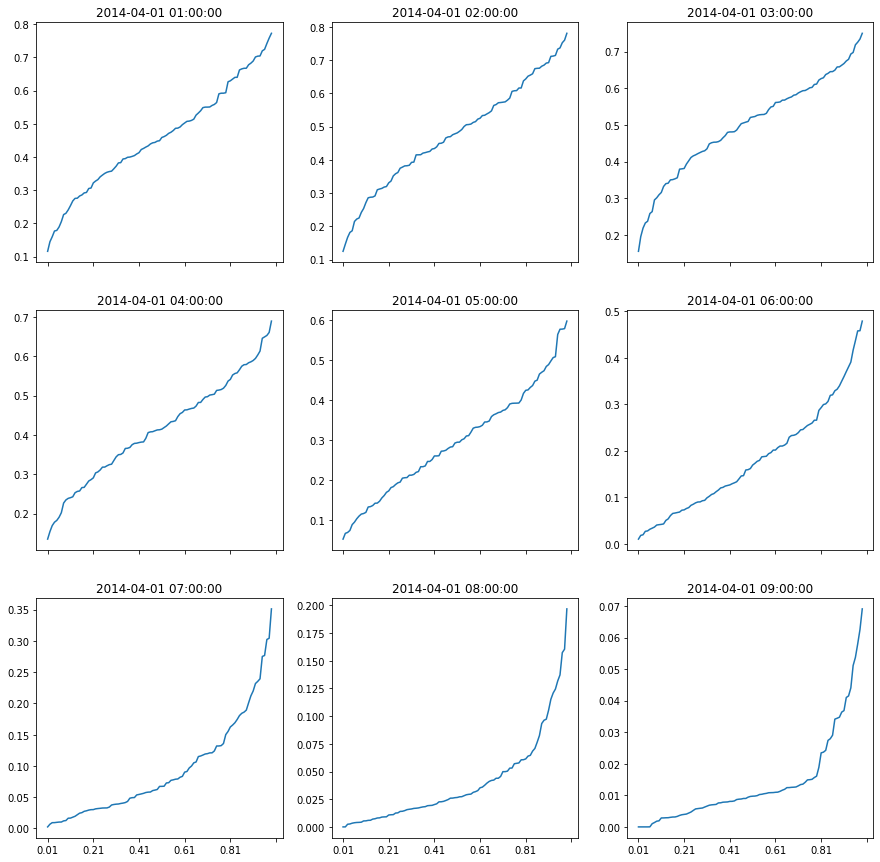

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 3, sharex=True, figsize=(15, 15))

for i in range(9):
    prediction.iloc[i].tail(99).plot(ax=ax[i // 3, i % 3],
                                     title=str(yq_output_df[-24*30:].index[i]))

# Evaluate Loss

The loss function is the pinnball loss:
$$ L(q_a, y) = \begin{cases}
    (1-\frac{a}{100})(q_a - y), &\text{if } y < q_a \\
    \frac{a}{100}(y-q_a), &\text{if } y \geq q_a.
\end{cases} $$

The score is then averaged over all target quantiles for all time periods over the forecast horizon and for all zones.

In [21]:
def pinnball_loss(actual, prediction):
    actual = actual[...,None]

    percentiles = np.empty((actual.shape[0], 99))
    for i in range(1, 100):
        percentiles[:, i-1] = i
    loss = np.where(actual < prediction,
                    (1 - percentiles / 100) * (prediction - actual),
                    percentiles / 100 * (actual - prediction))
    return loss

In [22]:
test_ts1 = np.squeeze(train_data_zones[0][-gefcom14_metadata['prediction_length']:].values)
test_ts2 = np.squeeze(train_data_zones[0][-gefcom14_metadata['prediction_length']:].values)
test_ts3 = np.squeeze(train_data_zones[0][-gefcom14_metadata['prediction_length']:].values)

prediction1 = prediction[prediction['ZONEID'] == 1].drop(columns='ZONEID')
prediction2 = prediction[prediction['ZONEID'] == 2].drop(columns='ZONEID')
prediction3 = prediction[prediction['ZONEID'] == 3].drop(columns='ZONEID')

loss1 = np.mean(pinnball_loss(test_ts1, prediction1))
loss2 = np.mean(pinnball_loss(test_ts2, prediction2))
loss3 = np.mean(pinnball_loss(test_ts3, prediction3))

loss = (loss1 + loss2 + loss3) / 3

print(f"Loss of task {task} with NNQF: {round(loss, 5)}")

Loss of task 14 with NNQF: 0.02299
